# Actividad 5 | Actividad de visualización de resultados
---

**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4034.10 - Análisis de grandes volúmenes de datos**

Tecnológico de Monterrey

* Dr. Iván Olmos Pineda
* Mtra. Verónica Sandra Guzmán de Valle
* Mtro. Alberto Daniel Salinas Montemayor

---

**Equipo 37**

|  NOMBRE COMPLETO                        |     MATRÍCULA     |
| :-------------------------------------: |:-----------------:|
| Alejandro Díaz Villagómez               |  A01276769        |
| Alonso Pedrero Martínez                 |  A01769076        |
| César Iván Pedrero Martínez             |  A01366501        |
| Emiliano Saucedo Arriola                |  A01659258        |

## 0. Inicialización

In [1]:
import findspark

from pyspark.sql import SparkSession, functions as F
from pyspark.sql import functions as F
from pyspark.sql.types import *
from functools import reduce
from operator import and_

import os
from concurrent.futures import ThreadPoolExecutor

import pandas as pd

from pyspark.sql import DataFrame
from pyspark.sql.functions import col, log1p
from pyspark.ml.feature import StringIndexer

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [2]:
findspark.init()
findspark.find()

'/Users/alejandrodiazvillagomez/Desktop/Proyecto-Big-Data-PySpark/.venv/lib/python3.12/site-packages/pyspark'

In [3]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

25/06/16 17:11:30 WARN Utils: Your hostname, Alejandros-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.100.221 instead (on interface en0)
25/06/16 17:11:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/16 17:11:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
class FileManager():
    @staticmethod
    def open_csv_file(file_path: str):
        """
        Abre un archivo CSV usando PySpark con configuraciones optimizadas
        """
        csv_df = spark.read.csv(
            file_path,
            header=True,
            inferSchema=True,
            multiLine=True,
            escape="\"",
            quote="\""
        )
        
        print(f"Dataset original cargado: {csv_df.count():,} registros")
        csv_df.show(5, truncate=20)
        return csv_df

In [5]:
import kagglehub

FILE_PATH = kagglehub.dataset_download("machharavikiran/amazon-reviews")
print("Path to dataset files:", FILE_PATH)

/Users/alejandrodiazvillagomez/Desktop/Proyecto-Big-Data-PySpark/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/alejandrodiazvillagomez/.cache/kagglehub/datasets/machharavikiran/amazon-reviews/versions/1


In [6]:
# Cargar dataset (población P)
df_reviews_P = FileManager.open_csv_file(FILE_PATH)

Dataset original cargado: 6,906,564 registros
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|sentiment|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|         US|   22873041|R3ARRMDEGED8RD|B00KJWQIIC|     335625766|Plemo 14-Inch Lap...|              PC|          5|            0|          0|   N|                Y|Pleasantly surprised|I was very surpri...| 2015-08-31|        1|
|         US|   30088427| RQ28TSA0

## 1.  Construcción de la muestra M

In [7]:
# Definir variables de caracterización
characterization_variables = ["star_rating", "verified_purchase", "vine"]

#### Análisis de la población P

En este apartado se realiza un análisis exploratorio sobre el dataset completo (población P). El objetivo es comprender la distribución general de las variables de caracterización (`star_rating`, `verified_purchase`, `vine`) y cómo se combinan entre sí, para identificar patrones, sesgos y grupos minoritarios.

In [8]:
# Analizar distribución de la población
total_count = df_reviews_P.count()
print(f"Tamaño total de la población P: {total_count:,} registros")

Tamaño total de la población P: 6,906,564 registros


In [9]:
# Calcular distribución de cada variable individual
for var in characterization_variables:
    print(f"\nDistribución de {var}:")
    var_dist = df_reviews_P.groupBy(var).count() \
                .withColumn("percentage", F.round(F.col("count") * 100.0 / total_count, 2)) \
                .orderBy("count", ascending=False)
    var_dist.show()


Distribución de star_rating:


+-----------+-------+----------+
|star_rating|  count|percentage|
+-----------+-------+----------+
|          5|4105687|     59.45|
|          4|1168208|     16.91|
|          1| 756857|     10.96|
|          3| 513656|      7.44|
|          2| 362156|      5.24|
+-----------+-------+----------+


Distribución de verified_purchase:


+-----------------+-------+----------+
|verified_purchase|  count|percentage|
+-----------------+-------+----------+
|                Y|6047075|     87.56|
|                N| 859489|     12.44|
+-----------------+-------+----------+


Distribución de vine:


+----+-------+----------+
|vine|  count|percentage|
+----+-------+----------+
|   N|6870336|     99.48|
|   Y|  36228|      0.52|
+----+-------+----------+



**Observaciones**

***Distribución de calificaciones (`star_rating`)***
* El 59.45% de las reseñas son de 5 estrellas, mostrando un fuerte sesgo positivo.
* Las reseñas con 1 estrella representan el 10.96%, mientras que las reseñas intermedias (2–4 estrellas) representan el resto.

***Distribución de compras verificadas (`verified_purchase`)***
* La gran mayoría (87.56%) proviene de usuarios con compra verificada, indicando que la base de datos tiene un fuerte enfoque en opiniones genuinas.

***Distribución del programa Vine (`vine`)***
* Solo el 52% de las reseñas provienen del programa Vine (usuarios seleccionados para reseñar productos), mientras que el 99.48% no pertenece a este grupo, haciéndolo un segmento muy minoritario.

In [10]:
# Calcular distribución conjunta
print(f"Distribución conjunta de {characterization_variables}:")
population_dist = df_reviews_P.groupBy(characterization_variables).count() \
                .withColumn("probability", F.round(F.col("count") / total_count, 6)) \
                .orderBy("probability", ascending=False)
population_dist.show(20)

Distribución conjunta de ['star_rating', 'verified_purchase', 'vine']:


+-----------+-----------------+----+-------+-----------+
|star_rating|verified_purchase|vine|  count|probability|
+-----------+-----------------+----+-------+-----------+
|          5|                Y|   N|3679909|   0.532813|
|          4|                Y|   N|1019728|   0.147646|
|          1|                Y|   N| 603371|   0.087362|
|          3|                Y|   N| 443364|   0.064195|
|          5|                N|   N| 410073|   0.059374|
|          2|                Y|   N| 300544|   0.043516|
|          1|                N|   N| 152779|   0.022121|
|          4|                N|   N| 135197|   0.019575|
|          3|                N|   N|  65398|   0.009469|
|          2|                N|   N|  59973|   0.008683|
|          5|                N|   Y|  15604|   0.002259|
|          4|                N|   Y|  13240|   0.001917|
|          3|                N|   Y|   4886|    7.07E-4|
|          2|                N|   Y|   1634|    2.37E-4|
|          1|                N|

**Observaciones**
* Más de la mitad son reseñas de 5 estrellas, verificadas y sin Vine (53.28%).
* Los grupos minoritarios, como reseñas de Vine con calificaciones bajas (1-3), tienen probabilidades extremadamente pequeñas.
* Esto confirma que la población está altamente desbalanceada, con algunos grupos muy dominantes y otros extremadamente escasos.

#### Filtrado de los estratos

In [11]:
# Identificar estratos relevantes (combinaciones con suficiente probabilidad)
min_probability = 0.0001
relevant_strata = population_dist.filter(F.col("probability") >= min_probability).collect()

print(f"Estratos identificados: {len(relevant_strata)}")
print(f"Probabilidad mínima requerida: {min_probability:.6f}")

Estratos identificados: 15
Probabilidad mínima requerida: 0.000100


**Observaciones**

Al analizar todas las combinaciones posibles de las variables de caracterización, se seleccionaron solo aquellos estratos (15 identificados) que tienen una probabilidad mínima (mayor o igual a 0.0001) de ocurrencia en la población. Esto asegura trabajar solo con grupos significativos.

#### Fracción de muestreo
A continuación, se construye un diccionario en el que se calcula la fracción de muestreo que se aplicará a cada estrato relevante para construir la muestra representativa M. Para mantener la diversidad y la representatividad de los datos, se optó por tomar el 10% de cada grupo, con un pequeño ajuste (~12%) para compensar la variabilidad aleatoria del muestreo y evitar que algunos grupos minoritarios terminen demasiado reducidos.

In [12]:
# Crear fracciones de muestreo para cada estrato
strata_fractions = {}
sample_fraction = 0.1
total_population = df_reviews_P.count()

for row in relevant_strata:
    # Crear clave única para el estrato
    star_label = f"R{row['star_rating']}"
    vp_label = f"VP{'Y' if row['verified_purchase'] == 'Y' else 'N'}"
    vine_label = f"V{'Y' if row['vine'] == 'Y' else 'N'}"

    strata_key = f"{star_label}_{vp_label}_{vine_label}"
    
    # Calcular fracción de muestreo para mantener representatividad
    strata_fraction = min(sample_fraction * 1.2, 0.5)  # Ligeramente mayor para compensar variabilidad
    strata_fractions[strata_key] = strata_fraction
    
    print(f"Estrato {strata_key}: {row['count']:,} registros, fracción: {strata_fraction:.3f}")

Estrato R5_VPY_VN: 3,679,909 registros, fracción: 0.120
Estrato R4_VPY_VN: 1,019,728 registros, fracción: 0.120
Estrato R1_VPY_VN: 603,371 registros, fracción: 0.120
Estrato R3_VPY_VN: 443,364 registros, fracción: 0.120
Estrato R5_VPN_VN: 410,073 registros, fracción: 0.120
Estrato R2_VPY_VN: 300,544 registros, fracción: 0.120
Estrato R1_VPN_VN: 152,779 registros, fracción: 0.120
Estrato R4_VPN_VN: 135,197 registros, fracción: 0.120
Estrato R3_VPN_VN: 65,398 registros, fracción: 0.120
Estrato R2_VPN_VN: 59,973 registros, fracción: 0.120
Estrato R5_VPN_VY: 15,604 registros, fracción: 0.120
Estrato R4_VPN_VY: 13,240 registros, fracción: 0.120
Estrato R3_VPN_VY: 4,886 registros, fracción: 0.120
Estrato R2_VPN_VY: 1,634 registros, fracción: 0.120
Estrato R1_VPN_VY: 705 registros, fracción: 0.120


#### Construcción de M

Para cada estrato, se filtran los registros y se toma una muestra utilizando la fracción previamente calculada. Este muestreo se realiza con una semilla fija (seed=42) para garantizar la reproducibilidad. Además, se asegura que no haya reemplazo (`withReplacement=False`), lo que significa que cada registro puede aparecer solo una vez en la muestra final.

Fuentes consultadas:
* https://www.geeksforgeeks.org/pyspark-random-sample-with-example/

In [13]:
# Aplicar muestreo estratificado
sample_parts = []

for row in relevant_strata:
    # Filtrar datos del estrato actual
    conditions = [F.col(var) == row[var] for var in characterization_variables]
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition = combined_condition & condition
    
    strata_data = df_reviews_P.filter(combined_condition)
    
    # Crear clave única para el estrato
    star_label = f"R{row['star_rating']}"
    vp_label = f"VP{'Y' if row['verified_purchase'] == 'Y' else 'N'}"
    vine_label = f"V{'Y' if row['vine'] == 'Y' else 'N'}"

    strata_key = f"{star_label}_{vp_label}_{vine_label}"
    fraction = strata_fractions[strata_key]
    
    # Aplicar muestreo con semilla fija para reproducibilidad
    sampled_strata = strata_data.sample(withReplacement=False, fraction=fraction, seed=42)
    sample_parts.append(sampled_strata)
    
    print(f"Muestreados {sampled_strata.count():,} de {strata_data.count():,} en estrato {strata_key}")

Muestreados 442,073 de 3,679,909 en estrato R5_VPY_VN


Muestreados 122,773 de 1,019,728 en estrato R4_VPY_VN


Muestreados 72,444 de 603,371 en estrato R1_VPY_VN


Muestreados 53,285 de 443,364 en estrato R3_VPY_VN


Muestreados 49,191 de 410,073 en estrato R5_VPN_VN


Muestreados 36,089 de 300,544 en estrato R2_VPY_VN


Muestreados 18,316 de 152,779 en estrato R1_VPN_VN


Muestreados 16,171 de 135,197 en estrato R4_VPN_VN


Muestreados 7,838 de 65,398 en estrato R3_VPN_VN


Muestreados 7,208 de 59,973 en estrato R2_VPN_VN


Muestreados 1,936 de 15,604 en estrato R5_VPN_VY


Muestreados 1,674 de 13,240 en estrato R4_VPN_VY


Muestreados 606 de 4,886 en estrato R3_VPN_VY


Muestreados 213 de 1,634 en estrato R2_VPN_VY


Muestreados 83 de 705 en estrato R1_VPN_VY


Posteriormente, se unen todas las submuestras recolectadas de los distintos estratos para construir la muestra representativa M. Esto se logra concatenando cada subconjunto, asegurando que todos los grupos seleccionados formen parte del conjunto final.

In [14]:
# Unir todas las partes para formar la muestra M
sample_M = sample_parts[0]
for part in sample_parts[1:]:
    sample_M = sample_M.union(part)

In [15]:
# Validar que la muestra M sea representativa de la población P
# Comparar distribuciones
pop_total = df_reviews_P.count()
sample_total = sample_M.count()

print(f"Población P: {pop_total:,} registros")
print(f"Muestra M: {sample_total:,} registros")
print(f"Factor de muestreo: {sample_total/pop_total:.1%}")

Población P: 6,906,564 registros
Muestra M: 829,900 registros
Factor de muestreo: 12.0%


**Observaciones**

Se obtuvo una muestra M de 829,900 registros, equivalente al 12% de la población original.

Aunque el objetivo inicial era obtener aproximadamente el 10%, el ajuste aplicado permitió compensar la variabilidad del proceso de muestreo y asegurar que los estratos más pequeños quedaran representados adecuadamente.

In [16]:
# Comparar distribución de cada variable
for var in characterization_variables:
    print(f"\n--- Comparación para {var} ---")
    
    # Distribución en población
    pop_dist = df_reviews_P.groupBy(var).count() \
                            .withColumn("pop_percentage", F.round(F.col("count") * 100.0 / pop_total, 2)) \
                            .select(var, F.col("pop_percentage"))
    
    # Distribución en muestra
    sample_dist = sample_M.groupBy(var).count() \
                            .withColumn("sample_percentage", F.round(F.col("count") * 100.0 / sample_total, 2)) \
                            .select(var, F.col("sample_percentage"))
    
    # Combinar para comparar
    comparison = pop_dist.join(sample_dist, on=var, how="outer") \
                        .fillna(0) \
                        .withColumn("difference", 
                                    F.abs(F.col("pop_percentage") - F.col("sample_percentage"))) \
                        .orderBy(var)
    
    comparison.show()
    
    # Calcular diferencia promedio
    avg_diff = comparison.agg(F.avg("difference")).collect()[0][0]
    print(f"Diferencia promedio en {var}: {avg_diff:.2f} puntos porcentuales")


--- Comparación para star_rating ---


+-----------+--------------+-----------------+--------------------+
|star_rating|pop_percentage|sample_percentage|          difference|
+-----------+--------------+-----------------+--------------------+
|          1|         10.96|            10.95|0.010000000000001563|
|          2|          5.24|             5.24|                 0.0|
|          3|          7.44|             7.44|                 0.0|
|          4|         16.91|            16.94|0.030000000000001137|
|          5|         59.45|            59.43|0.020000000000003126|
+-----------+--------------+-----------------+--------------------+



Diferencia promedio en star_rating: 0.01 puntos porcentuales

--- Comparación para verified_purchase ---


+-----------------+--------------+-----------------+----------+
|verified_purchase|pop_percentage|sample_percentage|difference|
+-----------------+--------------+-----------------+----------+
|                N|         12.44|            12.44|       0.0|
|                Y|         87.56|            87.56|       0.0|
+-----------------+--------------+-----------------+----------+



Diferencia promedio en verified_purchase: 0.00 puntos porcentuales

--- Comparación para vine ---


+----+--------------+-----------------+--------------------+
|vine|pop_percentage|sample_percentage|          difference|
+----+--------------+-----------------+--------------------+
|   N|         99.48|            99.46|0.020000000000010232|
|   Y|          0.52|             0.54|0.020000000000000018|
+----+--------------+-----------------+--------------------+



Diferencia promedio en vine: 0.02 puntos porcentuales


**Observaciones**

Con esta validación, nos aseguramos que el muestreo estratificado preservó las proporciones de la población, asegurando que la muestra sea representativa y fiable. Los resultados muestran que las diferencias promedio entre la población original y la muestra son casi nulas.

#### Particionamiento

A continuación, se crean las particiones Mi a partir de la muestra M, filtrando los datos para cada combinación de las variables de caracterización (star_rating, verified_purchase, vine). Para cada combinación, se construye dinámicamente una condición de filtrado que selecciona únicamente los registros que coinciden simultáneamente con esos valores específicos. Solo se conservan las particiones que tienen al menos 100 registros para asegurar que sean suficientemente representativas y útiles para construir más adelante los conjuntos de entrenamiento y prueba. Cada partición se guarda con un nombre descriptivo (como R5_VPY_VN), lo que permite identificar rápidamente a qué grupo pertenece. Al final, se obtiene un conjunto organizado de subconjuntos válidos.

In [17]:
# Identificar todas las combinaciones existentes en M
combinations = sample_M.select(characterization_variables).distinct().collect()

print(f"Combinaciones encontradas en M: {len(combinations)}")

Combinaciones encontradas en M: 15


In [18]:
# Crear particiones Mi
partitions_Mi = {}
total_partitioned = 0
min_partition_size = 100

for row in combinations:
    # Crear condiciones de filtrado
    combined_condition = reduce(and_, [F.col(var) == row[var] for var in characterization_variables])
    
    # Filtrar para crear la partición
    partition = sample_M.filter(combined_condition)
    partition_size = partition.count()
    
    # Solo incluir si cumple con el tamaño mínimo
    if partition_size >= min_partition_size:
        # Crear nombre descriptivo para la partición
        star_label = f"R{row['star_rating']}"
        vp_label = f"VP{'Y' if row['verified_purchase'] == 'Y' else 'N'}"
        vine_label = f"V{'Y' if row['vine'] == 'Y' else 'N'}"

        partition_key = f"{star_label}_{vp_label}_{vine_label}"
        partitions_Mi[partition_key] = partition
        total_partitioned += partition_size
        
        print(f"Partición {partition_key}: {partition_size:,} registros")
    else:
        key_values = [f"{var}={row[var]}" for var in characterization_variables]
        combination_str = ", ".join(key_values)
        print(f"Excluida combinación ({combination_str}): solo {partition_size} registros (< {min_partition_size})")

Partición R5_VPY_VN: 442,073 registros


Partición R4_VPY_VN: 122,773 registros


Partición R1_VPY_VN: 72,444 registros


Partición R3_VPY_VN: 53,285 registros


Partición R5_VPN_VN: 49,191 registros


Partición R2_VPY_VN: 36,089 registros


Partición R1_VPN_VN: 18,316 registros


Partición R4_VPN_VN: 16,171 registros


Partición R3_VPN_VN: 7,838 registros


Partición R2_VPN_VN: 7,208 registros


Partición R5_VPN_VY: 1,936 registros


Partición R4_VPN_VY: 1,674 registros


Partición R3_VPN_VY: 606 registros


Partición R2_VPN_VY: 213 registros


Excluida combinación (star_rating=1, verified_purchase=N, vine=Y): solo 83 registros (< 100)


In [19]:
# 3. Verificar que la unión de particiones = M
sample_M_size = sample_M.count()
coverage = total_partitioned / sample_M_size

print(f"\n=== RESUMEN DE PARTICIONAMIENTO ===")
print(f"Particiones Mi creadas: {len(partitions_Mi)}")
print(f"Registros en M: {sample_M_size:,}")
print(f"Registros particionados: {total_partitioned:,}")
print(f'Cobertura: {coverage * 100:.4f}%')


=== RESUMEN DE PARTICIONAMIENTO ===
Particiones Mi creadas: 14
Registros en M: 829,900
Registros particionados: 829,817
Cobertura: 99.9900%


**Observaciones**

Al ejecutar el particionamiento, se crearon 14 particiones Mi, que en conjunto cubren los registros de la muestra M (829,900 registros), donde 829,817 fueron particionados.


## 2. Definición del Proceso de Validación Cruzada k-Fold y Determinación del Valor de 'k'

### **a) Introducción a la Validación Cruzada**

La validación cruzada (`Cross-Validation`) es una técnica robusta para evaluar la capacidad de generalización de un modelo predictivo, mitigar el sobreajuste (*overfitting*) y estimar la variabilidad de los resultados del algoritmo en diferentes subconjuntos de datos. En particular, la validación cruzada `k-fold` divide el conjunto de datos disponible en `k` subconjuntos (o "folds") de tamaño aproximadamente igual. El proceso se repite k veces; en cada iteración, un fold se utiliza como conjunto de prueba y los k−1 restantes se combinan para formar el conjunto de entrenamiento. Las métricas de desempeño se calculan en cada iteración y se promedian para obtener una estimación más confiable de la capacidad de generalización del modelo. Este enfoque es crucial en entornos de Big Data, donde la simple división en *entrenamiento/prueba* podría no capturar adecuadamente la diversidad de la población y la variabilidad inherente a grandes volúmenes de datos.

### **b) Muestra de Referencia (M)**

El punto de partida para este proceso es la `Muestra M`, construida a partir de la población completa (`P`) de revisiones de Amazon. Como se detalla en las secciones previas de este cuaderno, la Muestra M (`sample_M` en nuestro código) ha sido generada mediante un muestreo estratificado. Este método garantiza que las proporciones de las variables de caracterización clave (`star_rating`, `verified_purchase`, y `vine`) se mantengan fieles a las observadas en la población P original.

La Muestra M tiene un tamaño de **829,900 registros**, lo que representa aproximadamente el 12.0% de la población total de 6,906,564 registros. Esta reducción del volumen de datos es estratégica en un contexto de Big Data, permitiendo la aplicación eficiente de técnicas de Feature Engineering y validación, al tiempo que se preserva la representatividad estadística.

Además, la Muestra M ha sido descompuesta en particiones `Mi`, donde cada Mi representa un estrato único definido por las combinaciones de las variables de caracterización. Se han identificado 14 particiones Mi que cumplen con un tamaño mínimo de 100 registros, cubriendo el 99.99% de la Muestra M. Esta granularidad en las particiones será fundamental para asegurar la representatividad en la construcción de los folds.

### **c) Determinación y Argumentación del Valor de 'k'**

La elección del valor de 'k' es un aspecto crítico que balancea la eficiencia computacional con la fiabilidad de la estimación del rendimiento del modelo. Un valor de 'k' demasiado bajo (ej., k=2 o k=3) puede resultar en una estimación de alta varianza, ya que cada conjunto de entrenamiento es significativamente más pequeño que el conjunto de datos completo, y el conjunto de prueba es grande, lo que podría no reflejar la verdadera generalización. Por otro lado, un 'k' muy alto (ej., k=50 o k=100) incrementa drásticamente el costo computacional (especialmente en Big Data), ya que se requieren más entrenamientos y evaluaciones, y los conjuntos de prueba se vuelven muy pequeños, lo que podría llevar a estimaciones de baja varianza pero alto sesgo.

Por ello, para este entregable, se ha determinado que un valor de `k = 5` es el más adecuado, basado en la siguiente argumentación:

* **Balance entre Sesgo y Varianza**: Un valor de k=5 es un compromiso ampliamente aceptado en la literatura de Machine Learning. Proporciona conjuntos de entrenamiento que comprenden el 80% de la Muestra M, lo cual es suficientemente grande para que los modelos aprendan patrones robustos. Simultáneamente, los conjuntos de prueba (20% de la Muestra M) son lo suficientemente grandes para obtener una estimación confiable del rendimiento. Esto ayuda a mitigar tanto el sesgo (subestimación del rendimiento) como la varianza (sensibilidad excesiva a la partición de los datos).

* **Eficiencia Computacional en Big Data**: Con una Muestra M de 829,900 registros, un k=5 implica 5 iteraciones de entrenamiento y evaluación. Cada iteración operará sobre un volumen manejable de datos (aproximadamente 664,000 registros para entrenamiento y 166,000 para prueba). Si bien PySpark está diseñado para escalar, un valor de 'k' excesivamente alto multiplicaría significativamente el tiempo de ejecución y el uso de recursos computacionales (CPU, memoria, I/O de red), lo que iría en contra de la optimización en un entorno de Big Data. En otras palabras, este valor permite una experimentación iterativa razonable sin incurrir en costos prohibitivos.

* **Garantía de Representatividad en cada Fold**: Para asegurar que cada uno de los k-folds sea una muestra representativa de la población, se implementará un proceso de muestreo estratificado en la construcción de los folds. Al igual que se hizo para generar la Muestra M a partir de la Población P, cada fold contendrá proporciones similares de las categorías de star_rating, verified_purchase, y vine que se observan en la Muestra M. Esto es crucial, especialmente para la variable vine, que presenta un desequilibrio significativo (0.52% 'Y' vs 99.48% 'N'). El muestreo estratificado en la construcción de los folds asegura que incluso las clases minoritarias estén adecuadamente representadas en cada conjunto de entrenamiento y prueba, lo cual es vital para la evaluación justa del modelo, especialmente si la tarea de aprendizaje se ve afectada por estas variables.

  * **Ejemplo de Representatividad por Estrato (Ilustrativo)**: Si el estrato 'R5_VPY_VN' (5 estrellas, compra verificada, no Vine) constituye ~53% de la Muestra M, se garantizará que en cada uno de los 5 folds, este estrato represente aproximadamente el 53% del fold. Este principio se aplicará a todas las 14 particiones Mi identificadas.

## 3. Construcción de los k-Folds para Validación Cruzada

La construcción de los **k-folds** es un paso fundamental que precede a la fase de entrenamiento y prueba. Basándonos en la Muestra M (`sample_M`) generada previamente, y con `k=5` como el número de pliegues definido, el objetivo es dividir sample_M en cinco subconjuntos disjuntos y representativos. Para garantizar la representatividad de cada fold, especialmente dada la naturaleza estratificada de la Muestra M y la necesidad de preservar las proporciones de las variables de caracterización (star_rating, verified_purchase, vine), emplearemos la función `randomSplit` de PySpark.

La función randomSplit permite dividir un DataFrame en múltiples DataFrames más pequeños basándose en ponderaciones especificadas. Al utilizar esta función con una semilla (`seed`) fija, aseguramos la reproducibilidad de los folds, lo cual es crucial para la consistencia en la experimentación y para la depuración. Cada subconjunto resultante será un fold, y la suma de las ponderaciones será 1 para cubrir la totalidad de la sample_M.

Considerando el volumen de datos (Big Data) y el costo computacional, esta aproximación es eficiente porque:

* **Opera sobre la Muestra M**: La división se realiza sobre la sample_M (829,900 registros), que ya es un subconjunto manejable de la población P. Esto evita operaciones costosas sobre el dataset completo.
* **Operación Distribuida**: randomSplit es una transformación de PySpark que se ejecuta de manera distribuida, aprovechando el clúster de Spark para procesar eficientemente grandes volúmenes de datos sin cargar excesivamente el nodo driver.
* **Simplicidad y Reproducibilidad**: La implementación es directa y la fijación de la semilla garantiza que los mismos folds se generarán cada vez que se ejecute el código, lo que es vital para la comparabilidad de experimentos.

In [20]:
import pyspark.sql.functions as F
from functools import reduce
from pyspark.sql import DataFrame

# Definimos el número de folds (k)
k = 5
print(f"Número de folds a construir (k): {k}")

# Definir las ponderaciones para randomSplit. Para k folds de tamaño aproximadamente igual, la ponderación para cada uno es 1/k
# randomSplit espera una lista de ponderaciones, una por cada sub-DataFrame
weights = [1.0/k] * k
print(f"Ponderaciones para cada fold: {weights}")

# Construir los k-folds utilizando randomSplit y una semilla fija para la reproducibilidad
folds = sample_M.randomSplit(weights, seed=42)

# Almacenamos los folds en un diccionario para fácil acceso
k_folds_dict = {}
for i, fold_df in enumerate(folds):
    fold_name = f"Fold_{i+1}"
    k_folds_dict[fold_name] = fold_df
    print(f"Fold '{fold_name}' creado con {fold_df.count():,} registros")

print("\n=== K-Folds Construidos Exitosamente ===")
print(f"Total de registros en Muestra M original: {sample_M.count():,}")
total_folds_count = sum(fold.count() for fold in k_folds_dict.values())
print(f"Total de registros en todos los folds combinados: {total_folds_count:,}")

# Verificamos que la suma de los folds sea igual a la muestra M (o muy cercana debido a la aproximación de randomSplit)
if abs(sample_M.count() - total_folds_count) < len(folds): # Pequeña tolerancia para randomSplit
    print("Verificación de tamaño: La suma de los folds es consistente con el tamaño de la Muestra M.")
else:
    print("Advertencia: La suma de los folds no coincide exactamente con el tamaño de la Muestra M.")

Número de folds a construir (k): 5
Ponderaciones para cada fold: [0.2, 0.2, 0.2, 0.2, 0.2]


Fold 'Fold_1' creado con 166,375 registros


Fold 'Fold_2' creado con 166,032 registros


Fold 'Fold_3' creado con 166,071 registros


Fold 'Fold_4' creado con 165,647 registros


Fold 'Fold_5' creado con 165,775 registros

=== K-Folds Construidos Exitosamente ===


Total de registros en Muestra M original: 829,900


Total de registros en todos los folds combinados: 829,900


Verificación de tamaño: La suma de los folds es consistente con el tamaño de la Muestra M.


La construcción de los cinco folds se realizó exitosamente sobre la muestra estratificada M, obteniendo subconjuntos de tamaño balanceado (aproximadamente 166 mil registros cada uno) y una suma total idéntica al tamaño original, lo que confirma la integridad del particionamiento. El uso de randomSplit con semilla fija garantiza la reproducibilidad del proceso, mientras que operar sobre una muestra previamente estratificada favorece la conservación de la representatividad en cada fold, base fundamental para una validación cruzada confiable en las siguientes etapas.

In [21]:
# Para asegurar que cada fold es representativo de la Muestra M y, por extensión, de la población, 
# verificaremos las distribuciones de las variables de caracterización (`star_rating`, `verified_purchase`, `vine`) 
# dentro de cada fold y las compararemos con la distribución de la `sample_M`
# Si `randomSplit` se aplica a una muestra ya estratificada, generalmente mantendrá esas proporciones, pero una verificación explícita es crucial

print("\n=== Verificación de Representatividad por Fold ===")

# Obtenemos la distribución de las variables de caracterización en la Muestra M
print("\nDistribución en la Muestra M (sample_M):")
total_sample_M_count = sample_M.count()
for var in characterization_variables:
    dist_M = sample_M.groupBy(var).count() \
                .withColumn("percentage", F.round(F.col("count") * 100.0 / total_sample_M_count, 2)) \
                .orderBy("count", ascending=False)
    print(f"  Variable: {var}")
    dist_M.show(5)

# Verificamos la distribución en el primer fold (Fold_1) como ejemplo
print("\nDistribución en el primer fold (Fold_1):")
first_fold_df = k_folds_dict["Fold_1"]
total_first_fold_count = first_fold_df.count()
for var in characterization_variables:
    dist_first_fold = first_fold_df.groupBy(var).count() \
                                    .withColumn("percentage", F.round(F.col("count") * 100.0 / total_first_fold_count, 2)) \
                                    .orderBy("count", ascending=False)
    print(f"  Variable: {var}")
    dist_first_fold.show(5)


=== Verificación de Representatividad por Fold ===

Distribución en la Muestra M (sample_M):


  Variable: star_rating


+-----------+------+----------+
|star_rating| count|percentage|
+-----------+------+----------+
|          5|493200|     59.43|
|          4|140618|     16.94|
|          1| 90843|     10.95|
|          3| 61729|      7.44|
|          2| 43510|      5.24|
+-----------+------+----------+

  Variable: verified_purchase


+-----------------+------+----------+
|verified_purchase| count|percentage|
+-----------------+------+----------+
|                Y|726664|     87.56|
|                N|103236|     12.44|
+-----------------+------+----------+

  Variable: vine


+----+------+----------+
|vine| count|percentage|
+----+------+----------+
|   N|825388|     99.46|
|   Y|  4512|      0.54|
+----+------+----------+


Distribución en el primer fold (Fold_1):


  Variable: star_rating


+-----------+-----+----------+
|star_rating|count|percentage|
+-----------+-----+----------+
|          5|98834|      59.4|
|          4|28420|     17.08|
|          1|18098|     10.88|
|          3|12252|      7.36|
|          2| 8771|      5.27|
+-----------+-----+----------+

  Variable: verified_purchase


+-----------------+------+----------+
|verified_purchase| count|percentage|
+-----------------+------+----------+
|                Y|145794|     87.63|
|                N| 20581|     12.37|
+-----------------+------+----------+

  Variable: vine


+----+------+----------+
|vine| count|percentage|
+----+------+----------+
|   N|165474|     99.46|
|   Y|   901|      0.54|
+----+------+----------+



Los resultados obtenidos al comparar las distribuciones de las variables de caracterización (star_rating, verified_purchase, vine) entre la muestra completa sample_M y el primer fold (Fold_1) confirman que las proporciones se mantienen prácticamente inalteradas. Esto valida que la aplicación de randomSplit sobre una muestra previamente estratificada conserva adecuadamente la representatividad interna de los datos, incluso en clases minoritarias como vine=Y. Por tanto, los folds generados son apropiados para realizar una validación cruzada confiable y sin sesgos atribuibles a desbalanceo estructural.

## 4. Fase de entrenamiento

Con base en los resultados obtenidos en la Actividad 4 del Módulo 5, el modelo que reportó el mejor desempeño fue el `Gradient Boosted Trees (GBTClassifier)`, el cual demostró ser especialmente efectivo para capturar relaciones no lineales y complejas entre las variables predictoras derivadas del comportamiento del usuario en reseñas de productos electrónicos de Amazon.

El objetivo del presente apartado es evaluar de forma exhaustiva la capacidad de generalización de dicho modelo aplicando un esquema de validación cruzada k-fold (`k=5`), basado en los folds generados previamente a partir de la muestra estratificada M.

Para garantizar una evaluación integral, se utilizarán las siguientes métricas, justificadas en función de la naturaleza del problema de clasificación binaria con clases desbalanceadas:

* **Accuracy**: Evalúa el porcentaje general de predicciones correctas.

* **Precision**: Mide la proporción de verdaderos positivos entre todas las predicciones positivas.

* **Recall**: Indica cuántos positivos reales fueron correctamente identificados.

* **F1-score**: Representa el balance entre precision y recall, útil ante clases desbalanceadas.

* **AUC-ROC**: Evalúa la capacidad del modelo para distinguir entre clases, independiente del umbral de decisión.

Estas métricas permitirán no solo valorar el desempeño general, sino también identificar posibles sesgos o desequilibrios en la clasificación. A continuación, se presenta el proceso experimental y los resultados obtenidos.

In [27]:
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql import DataFrame
from functools import reduce

class Preprocessor:
    def __init__(self, columns_for_modeling):
        self.columns = columns_for_modeling
        self.indexed_columns = []
    
    def merge_partitions(self, partition_dict: dict) -> DataFrame:
        # Nota: En este contexto de k-folds, usaremos unionByName para combinar folds.
        return reduce(lambda df1, df2: df1.unionByName(df2), partition_dict.values())
    
    def drop_nulls(self, df: DataFrame) -> DataFrame:
        initial_count = df.count()
        df_clean = df.dropna(subset=self.columns)
        final_count = df_clean.count()
        # print(f"Se eliminaron {initial_count - final_count} registros ({(initial_count - final_count) / initial_count:.2%})\n")
        return df_clean
    
    def remove_outliers(self, df: DataFrame, columns: list, quantile_error=0.01) -> DataFrame:
        # Optimizamos para no imprimir tanto en cada iteración de fold
        for col_name in columns:
            Q1, Q3 = df.approxQuantile(col_name, [0.25, 0.75], quantile_error)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            if IQR == 0:
                # print(f"Advertencia: IQR=0 para '{col_name}', se omite filtro de atípicos.")
                continue
            df = df.filter((F.col(col_name) >= lower_bound) & (F.col(col_name) <= upper_bound))
        return df
   
    def encode_categoricals(self, df: DataFrame) -> DataFrame:
        categorical_cols = ["vine", "verified_purchase"]
        # Reseteamos indexed_columns para cada preprocesamiento 
        self.indexed_columns = [] 
        
        pipeline_stages = []
        for col_name in categorical_cols:
            index_col = f"{col_name}_index"
            self.indexed_columns.append(index_col)
            indexer = StringIndexer(inputCol=col_name, outputCol=index_col, handleInvalid="keep") # handleInvalid para datos de prueba
            pipeline_stages.append(indexer)
        
        # Creamos un pipeline temporal para aplicar los indexers
        if pipeline_stages:
            temp_pipeline = Pipeline(stages=pipeline_stages)
            df = temp_pipeline.fit(df).transform(df)
        
        return df

In [ ]:
# Definimos las columnas necesarias para el modelo, incluyendo las que se crearán/transformarán:
# a) sentiment debe ser "0" o "1" (o IntegerType)
# b) star_rating es numérica, helpful_votes y total_votes también
# c) Necesitamos asegurar que 'sentiment' sea un tipo numérico (integer/double) para los clasificadores.
# d) PySpark MLlib GBTClassifier espera la etiqueta como DoubleType.

columns_for_modeling = [
    # "star_rating", # Quitamos star_rating del modelo
    "helpful_votes", "total_votes", 
    "vine", "verified_purchase", "sentiment" # Sentiment debe ser la etiqueta numérica
]

# Inicializamos el preprocesador
preprocessor = Preprocessor(columns_for_modeling=columns_for_modeling)

# Columnas para Feature Engineering
numerical_feature_cols = ["helpful_votes", "total_votes"] # Estas son las originales para las que se calculará FE
derived_feature_cols = ["vote_ratio", "log_total_votes", "log_helpful_votes"]

# Columnas de features finales para el GBT Classifier (incluyendo índices de categóricas)
# Estas se actualizarán dinámicamente con los nombres de las columnas indexadas
feature_cols = [
    # "star_rating", # Quitamos star_rating del modelo
    "log_helpful_votes", 
    "log_total_votes", 
    "vote_ratio"
    # "vine_index", # Se agregará programáticamente después del encoding
    # "verified_purchase_index" # Se agregará programáticamente después del encoding
]

In [30]:
# Lista para almacenar los resultados de cada fold y los modelos entrenados
experiment_results = []
trained_models = {} 
i = 0

print("\n=== Inicio de la Fase de Experimentación con GBT Classifier ===")


=== Inicio de la Fase de Experimentación con GBT Classifier ===


In [31]:
# Procesamos el fold actual
if i < k:
    print(f"\n--- Procesando Fold {i+1}/{k} ---")
    test_fold = k_folds_dict[f"Fold_{i+1}"]

    # Combinamos los k-1 folds restantes para el entrenamiento
    train_folds_list = []
    for j in range(k):
        if j != i:
            train_folds_list.append(k_folds_dict[f"Fold_{j+1}"])

    # Unimos los DataFrames de entrenamiento con unionByName
    df_train = reduce(lambda df1, df2: df1.unionByName(df2), train_folds_list)
    df_test = test_fold 

    print(f"Tamaño del conjunto de entrenamiento: {df_train.count():,} registros")
    print(f"Tamaño del conjunto de prueba: {df_test.count():,} registros")

    # --- Preprocesamiento y Feature Engineering ---
    # 1. Aseguramos que 'sentiment' sea de tipo Double para PySpark MLlib
    df_train = df_train.withColumn("sentiment", F.col("sentiment").cast("double"))
    df_test = df_test.withColumn("sentiment", F.col("sentiment").cast("double"))
    print("Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.")

    # 2. Eliminamos nulos en columnas clave
    df_train_processed = preprocessor.drop_nulls(df_train)
    df_test_processed = preprocessor.drop_nulls(df_test) 
    print("Paso 2: Eliminamos registros con nulos en columnas clave.")

    # 3. Removemos Outliers (si aplica, para columnas específicas)
    df_train_processed = preprocessor.remove_outliers(df_train_processed, numerical_feature_cols)
    df_test_processed = preprocessor.remove_outliers(df_test_processed, numerical_feature_cols)
    print("Paso 3: Eliminamos outliers en columnas numéricas clave.")

    # 4. Feature Engineering
    df_train_fe = df_train_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    df_test_fe = df_test_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    print("Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.")

    # 5. Codificación de variables categóricas (StringIndexer)
    categorical_cols = ["vine", "verified_purchase"]
    indexer_stages = []
    current_feature_cols = list(feature_cols) # Copia las features base

    for col_name in categorical_cols:
        index_col = f"{col_name}_index"
        indexer = StringIndexer(inputCol=col_name, outputCol=index_col, handleInvalid="keep")
        indexer_stages.append(indexer)
        current_feature_cols.append(index_col) # Añadimos al listado de features

    # Creamos un pipeline temporal para los indexers y lo aplicamos a train y test
    temp_indexer_pipeline = Pipeline(stages=indexer_stages)
    temp_indexer_model = temp_indexer_pipeline.fit(df_train_fe)

    df_train_final = temp_indexer_model.transform(df_train_fe)
    df_test_final = temp_indexer_model.transform(df_test_fe)
    print("Paso 5: Codificamos variables categóricas usando StringIndexer.")

    # Aseguramos que feature_cols tenga los nombres correctos para el assembler y que 'sentiment' sea la etiqueta
    final_feature_cols_for_assembler = [col for col in current_feature_cols if col in df_train_final.columns]

    # --- Configuración y Entrenamiento del Modelo GBT ---
    assembler = VectorAssembler(inputCols=final_feature_cols_for_assembler, outputCol="features")
    gbt = GBTClassifier(featuresCol="features", labelCol="sentiment", seed=42) # Usar seed para reproducibilidad

    # Pipeline del modelo
    model_pipeline = Pipeline(stages=[assembler, gbt])

    # Entrenamiento del modelo
    print(f"Entrenando GBT para Fold {i+1}...")
    gbt_model_trained = model_pipeline.fit(df_train_final)

    # Almacenar el modelo entrenado (opcional, útil para debugging o despliegue)
    trained_models[f"Fold_{i+1}"] = gbt_model_trained

    # --- Predicciones y Evaluación ---
    predictions = gbt_model_trained.transform(df_test_final)

    # Evaluadores de métricas
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
    evaluator_auc_roc = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

    accuracy = evaluator_accuracy.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    auc_roc = evaluator_auc_roc.evaluate(predictions)

    # Registro de resultados para el fold actual
    fold_results = {
        "fold": i + 1,
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "auc_roc": auc_roc,
        "train_size": df_train_final.count(),
        "test_size": df_test_final.count()
    }
    experiment_results.append(fold_results)

    print(f"Resultados de Fold {i+1}:")
    print(f"\tAccuracy: {accuracy:.4f}")
    print(f"\tF1 Score: {f1:.4f}")
    print(f"\tPrecision: {precision:.4f}")
    print(f"\tRecall: {recall:.4f}")
    print(f"\tAUC-ROC: {auc_roc:.4f}")

    i += 1
else:
    print(f"Todos los folds ya han sido procesados. No hay más folds para procesar.")


--- Procesando Fold 1/5 ---


Tamaño del conjunto de entrenamiento: 663,525 registros


Tamaño del conjunto de prueba: 166,375 registros
Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.


Paso 2: Eliminamos registros con nulos en columnas clave.


Paso 3: Eliminamos outliers en columnas numéricas clave.
Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.


Paso 5: Codificamos variables categóricas usando StringIndexer.
Entrenando GBT para Fold 1...


Resultados de Fold 1:
	Accuracy: 0.7963
	F1 Score: 0.7160
	Precision: 0.7511
	Recall: 0.7963
	AUC-ROC: 0.5905


In [32]:
# Procesamos el fold actual
if i < k:
    print(f"\n--- Procesando Fold {i+1}/{k} ---")
    test_fold = k_folds_dict[f"Fold_{i+1}"]

    # Combinamos los k-1 folds restantes para el entrenamiento
    train_folds_list = []
    for j in range(k):
        if j != i:
            train_folds_list.append(k_folds_dict[f"Fold_{j+1}"])

    # Unimos los DataFrames de entrenamiento con unionByName
    df_train = reduce(lambda df1, df2: df1.unionByName(df2), train_folds_list)
    df_test = test_fold 

    print(f"Tamaño del conjunto de entrenamiento: {df_train.count():,} registros")
    print(f"Tamaño del conjunto de prueba: {df_test.count():,} registros")

    # --- Preprocesamiento y Feature Engineering ---
    # 1. Aseguramos que 'sentiment' sea de tipo Double para PySpark MLlib
    df_train = df_train.withColumn("sentiment", F.col("sentiment").cast("double"))
    df_test = df_test.withColumn("sentiment", F.col("sentiment").cast("double"))
    print("Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.")

    # 2. Eliminamos nulos en columnas clave
    df_train_processed = preprocessor.drop_nulls(df_train)
    df_test_processed = preprocessor.drop_nulls(df_test) 
    print("Paso 2: Eliminamos registros con nulos en columnas clave.")

    # 3. Removemos Outliers (si aplica, para columnas específicas)
    df_train_processed = preprocessor.remove_outliers(df_train_processed, numerical_feature_cols)
    df_test_processed = preprocessor.remove_outliers(df_test_processed, numerical_feature_cols)
    print("Paso 3: Eliminamos outliers en columnas numéricas clave.")

    # 4. Feature Engineering
    df_train_fe = df_train_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    df_test_fe = df_test_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    print("Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.")

    # 5. Codificación de variables categóricas (StringIndexer)
    categorical_cols = ["vine", "verified_purchase"]
    indexer_stages = []
    current_feature_cols = list(feature_cols) # Copia las features base

    for col_name in categorical_cols:
        index_col = f"{col_name}_index"
        indexer = StringIndexer(inputCol=col_name, outputCol=index_col, handleInvalid="keep")
        indexer_stages.append(indexer)
        current_feature_cols.append(index_col) # Añadimos al listado de features

    # Creamos un pipeline temporal para los indexers y lo aplicamos a train y test
    temp_indexer_pipeline = Pipeline(stages=indexer_stages)
    temp_indexer_model = temp_indexer_pipeline.fit(df_train_fe)

    df_train_final = temp_indexer_model.transform(df_train_fe)
    df_test_final = temp_indexer_model.transform(df_test_fe)
    print("Paso 5: Codificamos variables categóricas usando StringIndexer.")

    # Aseguramos que feature_cols tenga los nombres correctos para el assembler y que 'sentiment' sea la etiqueta
    final_feature_cols_for_assembler = [col for col in current_feature_cols if col in df_train_final.columns]

    # --- Configuración y Entrenamiento del Modelo GBT ---
    assembler = VectorAssembler(inputCols=final_feature_cols_for_assembler, outputCol="features")
    gbt = GBTClassifier(featuresCol="features", labelCol="sentiment", seed=42) # Usar seed para reproducibilidad

    # Pipeline del modelo
    model_pipeline = Pipeline(stages=[assembler, gbt])

    # Entrenamiento del modelo
    print(f"Entrenando GBT para Fold {i+1}...")
    gbt_model_trained = model_pipeline.fit(df_train_final)

    # Almacenar el modelo entrenado (opcional, útil para debugging o despliegue)
    trained_models[f"Fold_{i+1}"] = gbt_model_trained

    # --- Predicciones y Evaluación ---
    predictions = gbt_model_trained.transform(df_test_final)

    # Evaluadores de métricas
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
    evaluator_auc_roc = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

    accuracy = evaluator_accuracy.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    auc_roc = evaluator_auc_roc.evaluate(predictions)

    # Registro de resultados para el fold actual
    fold_results = {
        "fold": i + 1,
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "auc_roc": auc_roc,
        "train_size": df_train_final.count(),
        "test_size": df_test_final.count()
    }
    experiment_results.append(fold_results)

    print(f"Resultados de Fold {i+1}:")
    print(f"\tAccuracy: {accuracy:.4f}")
    print(f"\tF1 Score: {f1:.4f}")
    print(f"\tPrecision: {precision:.4f}")
    print(f"\tRecall: {recall:.4f}")
    print(f"\tAUC-ROC: {auc_roc:.4f}")

    i += 1
else:
    print(f"Todos los folds ya han sido procesados. No hay más folds para procesar.")


--- Procesando Fold 2/5 ---


Tamaño del conjunto de entrenamiento: 663,868 registros


Tamaño del conjunto de prueba: 166,032 registros
Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.


Paso 2: Eliminamos registros con nulos en columnas clave.


Paso 3: Eliminamos outliers en columnas numéricas clave.
Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.


Paso 5: Codificamos variables categóricas usando StringIndexer.
Entrenando GBT para Fold 2...


Resultados de Fold 2:
	Accuracy: 0.7950
	F1 Score: 0.7138
	Precision: 0.7433
	Recall: 0.7950
	AUC-ROC: 0.5889


In [33]:
# Procesamos el fold actual
if i < k:
    print(f"\n--- Procesando Fold {i+1}/{k} ---")
    test_fold = k_folds_dict[f"Fold_{i+1}"]

    # Combinamos los k-1 folds restantes para el entrenamiento
    train_folds_list = []
    for j in range(k):
        if j != i:
            train_folds_list.append(k_folds_dict[f"Fold_{j+1}"])

    # Unimos los DataFrames de entrenamiento con unionByName
    df_train = reduce(lambda df1, df2: df1.unionByName(df2), train_folds_list)
    df_test = test_fold 

    print(f"Tamaño del conjunto de entrenamiento: {df_train.count():,} registros")
    print(f"Tamaño del conjunto de prueba: {df_test.count():,} registros")

    # --- Preprocesamiento y Feature Engineering ---
    # 1. Aseguramos que 'sentiment' sea de tipo Double para PySpark MLlib
    df_train = df_train.withColumn("sentiment", F.col("sentiment").cast("double"))
    df_test = df_test.withColumn("sentiment", F.col("sentiment").cast("double"))
    print("Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.")

    # 2. Eliminamos nulos en columnas clave
    df_train_processed = preprocessor.drop_nulls(df_train)
    df_test_processed = preprocessor.drop_nulls(df_test) 
    print("Paso 2: Eliminamos registros con nulos en columnas clave.")

    # 3. Removemos Outliers (si aplica, para columnas específicas)
    df_train_processed = preprocessor.remove_outliers(df_train_processed, numerical_feature_cols)
    df_test_processed = preprocessor.remove_outliers(df_test_processed, numerical_feature_cols)
    print("Paso 3: Eliminamos outliers en columnas numéricas clave.")

    # 4. Feature Engineering
    df_train_fe = df_train_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    df_test_fe = df_test_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    print("Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.")

    # 5. Codificación de variables categóricas (StringIndexer)
    categorical_cols = ["vine", "verified_purchase"]
    indexer_stages = []
    current_feature_cols = list(feature_cols) # Copia las features base

    for col_name in categorical_cols:
        index_col = f"{col_name}_index"
        indexer = StringIndexer(inputCol=col_name, outputCol=index_col, handleInvalid="keep")
        indexer_stages.append(indexer)
        current_feature_cols.append(index_col) # Añadimos al listado de features

    # Creamos un pipeline temporal para los indexers y lo aplicamos a train y test
    temp_indexer_pipeline = Pipeline(stages=indexer_stages)
    temp_indexer_model = temp_indexer_pipeline.fit(df_train_fe)

    df_train_final = temp_indexer_model.transform(df_train_fe)
    df_test_final = temp_indexer_model.transform(df_test_fe)
    print("Paso 5: Codificamos variables categóricas usando StringIndexer.")

    # Aseguramos que feature_cols tenga los nombres correctos para el assembler y que 'sentiment' sea la etiqueta
    final_feature_cols_for_assembler = [col for col in current_feature_cols if col in df_train_final.columns]

    # --- Configuración y Entrenamiento del Modelo GBT ---
    assembler = VectorAssembler(inputCols=final_feature_cols_for_assembler, outputCol="features")
    gbt = GBTClassifier(featuresCol="features", labelCol="sentiment", seed=42) # Usar seed para reproducibilidad

    # Pipeline del modelo
    model_pipeline = Pipeline(stages=[assembler, gbt])

    # Entrenamiento del modelo
    print(f"Entrenando GBT para Fold {i+1}...")
    gbt_model_trained = model_pipeline.fit(df_train_final)

    # Almacenar el modelo entrenado (opcional, útil para debugging o despliegue)
    trained_models[f"Fold_{i+1}"] = gbt_model_trained

    # --- Predicciones y Evaluación ---
    predictions = gbt_model_trained.transform(df_test_final)

    # Evaluadores de métricas
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
    evaluator_auc_roc = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

    accuracy = evaluator_accuracy.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    auc_roc = evaluator_auc_roc.evaluate(predictions)

    # Registro de resultados para el fold actual
    fold_results = {
        "fold": i + 1,
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "auc_roc": auc_roc,
        "train_size": df_train_final.count(),
        "test_size": df_test_final.count()
    }
    experiment_results.append(fold_results)

    print(f"Resultados de Fold {i+1}:")
    print(f"\tAccuracy: {accuracy:.4f}")
    print(f"\tF1 Score: {f1:.4f}")
    print(f"\tPrecision: {precision:.4f}")
    print(f"\tRecall: {recall:.4f}")
    print(f"\tAUC-ROC: {auc_roc:.4f}")

    i += 1
else:
    print(f"Todos los folds ya han sido procesados. No hay más folds para procesar.")


--- Procesando Fold 3/5 ---


Tamaño del conjunto de entrenamiento: 663,829 registros


Tamaño del conjunto de prueba: 166,071 registros
Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.


Paso 2: Eliminamos registros con nulos en columnas clave.


Paso 3: Eliminamos outliers en columnas numéricas clave.
Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.


Paso 5: Codificamos variables categóricas usando StringIndexer.
Entrenando GBT para Fold 3...


Resultados de Fold 3:
	Accuracy: 0.7951
	F1 Score: 0.7143
	Precision: 0.7493
	Recall: 0.7951
	AUC-ROC: 0.5894


In [34]:
# Procesamos el fold actual
if i < k:
    print(f"\n--- Procesando Fold {i+1}/{k} ---")
    test_fold = k_folds_dict[f"Fold_{i+1}"]

    # Combinamos los k-1 folds restantes para el entrenamiento
    train_folds_list = []
    for j in range(k):
        if j != i:
            train_folds_list.append(k_folds_dict[f"Fold_{j+1}"])

    # Unimos los DataFrames de entrenamiento con unionByName
    df_train = reduce(lambda df1, df2: df1.unionByName(df2), train_folds_list)
    df_test = test_fold 

    print(f"Tamaño del conjunto de entrenamiento: {df_train.count():,} registros")
    print(f"Tamaño del conjunto de prueba: {df_test.count():,} registros")

    # --- Preprocesamiento y Feature Engineering ---
    # 1. Aseguramos que 'sentiment' sea de tipo Double para PySpark MLlib
    df_train = df_train.withColumn("sentiment", F.col("sentiment").cast("double"))
    df_test = df_test.withColumn("sentiment", F.col("sentiment").cast("double"))
    print("Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.")

    # 2. Eliminamos nulos en columnas clave
    df_train_processed = preprocessor.drop_nulls(df_train)
    df_test_processed = preprocessor.drop_nulls(df_test) 
    print("Paso 2: Eliminamos registros con nulos en columnas clave.")

    # 3. Removemos Outliers (si aplica, para columnas específicas)
    df_train_processed = preprocessor.remove_outliers(df_train_processed, numerical_feature_cols)
    df_test_processed = preprocessor.remove_outliers(df_test_processed, numerical_feature_cols)
    print("Paso 3: Eliminamos outliers en columnas numéricas clave.")

    # 4. Feature Engineering
    df_train_fe = df_train_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    df_test_fe = df_test_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    print("Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.")

    # 5. Codificación de variables categóricas (StringIndexer)
    categorical_cols = ["vine", "verified_purchase"]
    indexer_stages = []
    current_feature_cols = list(feature_cols) # Copia las features base

    for col_name in categorical_cols:
        index_col = f"{col_name}_index"
        indexer = StringIndexer(inputCol=col_name, outputCol=index_col, handleInvalid="keep")
        indexer_stages.append(indexer)
        current_feature_cols.append(index_col) # Añadimos al listado de features

    # Creamos un pipeline temporal para los indexers y lo aplicamos a train y test
    temp_indexer_pipeline = Pipeline(stages=indexer_stages)
    temp_indexer_model = temp_indexer_pipeline.fit(df_train_fe)

    df_train_final = temp_indexer_model.transform(df_train_fe)
    df_test_final = temp_indexer_model.transform(df_test_fe)
    print("Paso 5: Codificamos variables categóricas usando StringIndexer.")

    # Aseguramos que feature_cols tenga los nombres correctos para el assembler y que 'sentiment' sea la etiqueta
    final_feature_cols_for_assembler = [col for col in current_feature_cols if col in df_train_final.columns]

    # --- Configuración y Entrenamiento del Modelo GBT ---
    assembler = VectorAssembler(inputCols=final_feature_cols_for_assembler, outputCol="features")
    gbt = GBTClassifier(featuresCol="features", labelCol="sentiment", seed=42) # Usar seed para reproducibilidad

    # Pipeline del modelo
    model_pipeline = Pipeline(stages=[assembler, gbt])

    # Entrenamiento del modelo
    print(f"Entrenando GBT para Fold {i+1}...")
    gbt_model_trained = model_pipeline.fit(df_train_final)

    # Almacenar el modelo entrenado (opcional, útil para debugging o despliegue)
    trained_models[f"Fold_{i+1}"] = gbt_model_trained

    # --- Predicciones y Evaluación ---
    predictions = gbt_model_trained.transform(df_test_final)

    # Evaluadores de métricas
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
    evaluator_auc_roc = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

    accuracy = evaluator_accuracy.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    auc_roc = evaluator_auc_roc.evaluate(predictions)

    # Registro de resultados para el fold actual
    fold_results = {
        "fold": i + 1,
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "auc_roc": auc_roc,
        "train_size": df_train_final.count(),
        "test_size": df_test_final.count()
    }
    experiment_results.append(fold_results)

    print(f"Resultados de Fold {i+1}:")
    print(f"\tAccuracy: {accuracy:.4f}")
    print(f"\tF1 Score: {f1:.4f}")
    print(f"\tPrecision: {precision:.4f}")
    print(f"\tRecall: {recall:.4f}")
    print(f"\tAUC-ROC: {auc_roc:.4f}")

    i += 1
else:
    print(f"Todos los folds ya han sido procesados. No hay más folds para procesar.")


--- Procesando Fold 4/5 ---


Tamaño del conjunto de entrenamiento: 664,253 registros


Tamaño del conjunto de prueba: 165,647 registros
Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.


Paso 2: Eliminamos registros con nulos en columnas clave.


Paso 3: Eliminamos outliers en columnas numéricas clave.
Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.


Paso 5: Codificamos variables categóricas usando StringIndexer.
Entrenando GBT para Fold 4...


Resultados de Fold 4:
	Accuracy: 0.7945
	F1 Score: 0.7128
	Precision: 0.7442
	Recall: 0.7945
	AUC-ROC: 0.5906


In [35]:
# Procesamos el fold actual
if i < k:
    print(f"\n--- Procesando Fold {i+1}/{k} ---")
    test_fold = k_folds_dict[f"Fold_{i+1}"]

    # Combinamos los k-1 folds restantes para el entrenamiento
    train_folds_list = []
    for j in range(k):
        if j != i:
            train_folds_list.append(k_folds_dict[f"Fold_{j+1}"])

    # Unimos los DataFrames de entrenamiento con unionByName
    df_train = reduce(lambda df1, df2: df1.unionByName(df2), train_folds_list)
    df_test = test_fold 

    print(f"Tamaño del conjunto de entrenamiento: {df_train.count():,} registros")
    print(f"Tamaño del conjunto de prueba: {df_test.count():,} registros")

    # --- Preprocesamiento y Feature Engineering ---
    # 1. Aseguramos que 'sentiment' sea de tipo Double para PySpark MLlib
    df_train = df_train.withColumn("sentiment", F.col("sentiment").cast("double"))
    df_test = df_test.withColumn("sentiment", F.col("sentiment").cast("double"))
    print("Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.")

    # 2. Eliminamos nulos en columnas clave
    df_train_processed = preprocessor.drop_nulls(df_train)
    df_test_processed = preprocessor.drop_nulls(df_test) 
    print("Paso 2: Eliminamos registros con nulos en columnas clave.")

    # 3. Removemos Outliers (si aplica, para columnas específicas)
    df_train_processed = preprocessor.remove_outliers(df_train_processed, numerical_feature_cols)
    df_test_processed = preprocessor.remove_outliers(df_test_processed, numerical_feature_cols)
    print("Paso 3: Eliminamos outliers en columnas numéricas clave.")

    # 4. Feature Engineering
    df_train_fe = df_train_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    df_test_fe = df_test_processed \
        .withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
        .withColumn("log_total_votes", F.log1p(F.col("total_votes"))) \
        .withColumn("log_helpful_votes", F.log1p(F.col("helpful_votes")))
    print("Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.")

    # 5. Codificación de variables categóricas (StringIndexer)
    categorical_cols = ["vine", "verified_purchase"]
    indexer_stages = []
    current_feature_cols = list(feature_cols) # Copia las features base

    for col_name in categorical_cols:
        index_col = f"{col_name}_index"
        indexer = StringIndexer(inputCol=col_name, outputCol=index_col, handleInvalid="keep")
        indexer_stages.append(indexer)
        current_feature_cols.append(index_col) # Añadimos al listado de features

    # Creamos un pipeline temporal para los indexers y lo aplicamos a train y test
    temp_indexer_pipeline = Pipeline(stages=indexer_stages)
    temp_indexer_model = temp_indexer_pipeline.fit(df_train_fe)

    df_train_final = temp_indexer_model.transform(df_train_fe)
    df_test_final = temp_indexer_model.transform(df_test_fe)
    print("Paso 5: Codificamos variables categóricas usando StringIndexer.")

    # Aseguramos que feature_cols tenga los nombres correctos para el assembler y que 'sentiment' sea la etiqueta
    final_feature_cols_for_assembler = [col for col in current_feature_cols if col in df_train_final.columns]

    # --- Configuración y Entrenamiento del Modelo GBT ---
    assembler = VectorAssembler(inputCols=final_feature_cols_for_assembler, outputCol="features")
    gbt = GBTClassifier(featuresCol="features", labelCol="sentiment", seed=42) # Usar seed para reproducibilidad

    # Pipeline del modelo
    model_pipeline = Pipeline(stages=[assembler, gbt])

    # Entrenamiento del modelo
    print(f"Entrenando GBT para Fold {i+1}...")
    gbt_model_trained = model_pipeline.fit(df_train_final)

    # Almacenar el modelo entrenado (opcional, útil para debugging o despliegue)
    trained_models[f"Fold_{i+1}"] = gbt_model_trained

    # --- Predicciones y Evaluación ---
    predictions = gbt_model_trained.transform(df_test_final)

    # Evaluadores de métricas
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
    evaluator_auc_roc = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

    accuracy = evaluator_accuracy.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    auc_roc = evaluator_auc_roc.evaluate(predictions)

    # Registro de resultados para el fold actual
    fold_results = {
        "fold": i + 1,
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "auc_roc": auc_roc,
        "train_size": df_train_final.count(),
        "test_size": df_test_final.count()
    }
    experiment_results.append(fold_results)

    print(f"Resultados de Fold {i+1}:")
    print(f"\tAccuracy: {accuracy:.4f}")
    print(f"\tF1 Score: {f1:.4f}")
    print(f"\tPrecision: {precision:.4f}")
    print(f"\tRecall: {recall:.4f}")
    print(f"\tAUC-ROC: {auc_roc:.4f}")

    i += 1
else:
    print(f"Todos los folds ya han sido procesados. No hay más folds para procesar.")


--- Procesando Fold 5/5 ---


Tamaño del conjunto de entrenamiento: 664,125 registros


Tamaño del conjunto de prueba: 165,775 registros
Paso 1: Convertimos 'sentiment' a tipo Double para entrenamiento y prueba.


Paso 2: Eliminamos registros con nulos en columnas clave.


Paso 3: Eliminamos outliers en columnas numéricas clave.
Paso 4: Aplicamos Feature Engineering para crear nuevas columnas.


Paso 5: Codificamos variables categóricas usando StringIndexer.
Entrenando GBT para Fold 5...


Resultados de Fold 5:
	Accuracy: 0.7958
	F1 Score: 0.7146
	Precision: 0.7473
	Recall: 0.7958
	AUC-ROC: 0.5920


In [36]:
# Imprimimos un resumen de todos los resultados
print("\n--- Resumen de Resultados por Fold ---")
for result in experiment_results:
    print(f"Fold {result['fold']}: Acc={result['accuracy']:.4f}, F1={result['f1_score']:.4f}, Prec={result['precision']:.4f}, Rec={result['recall']:.4f}, AUC={result['auc_roc']:.4f}")

# Calculamos las estadísticas de los resultados (media, desviación estándar)
import pandas as pd
results_df = pd.DataFrame(experiment_results)

print("\n--- Estadísticas de las Métricas (Media y Desviación Estándar) ---")
print(results_df.mean(numeric_only=True))

print("\n--- Desviación Estándar ---")
print(results_df.std(numeric_only=True))


--- Resumen de Resultados por Fold ---
Fold 1: Acc=0.7963, F1=0.7160, Prec=0.7511, Rec=0.7963, AUC=0.5905
Fold 2: Acc=0.7950, F1=0.7138, Prec=0.7433, Rec=0.7950, AUC=0.5889
Fold 3: Acc=0.7951, F1=0.7143, Prec=0.7493, Rec=0.7951, AUC=0.5894
Fold 4: Acc=0.7945, F1=0.7128, Prec=0.7442, Rec=0.7945, AUC=0.5906
Fold 5: Acc=0.7958, F1=0.7146, Prec=0.7473, Rec=0.7958, AUC=0.5920

--- Estadísticas de las Métricas (Media y Desviación Estándar) ---
fold               3.000000
accuracy           0.795358
f1_score           0.714307
precision          0.747035
recall             0.795358
auc_roc            0.590273
train_size    579320.800000
test_size     144830.200000
dtype: float64

--- Desviación Estándar ---
fold            1.581139
accuracy        0.000712
f1_score        0.001166
precision       0.003295
recall          0.000712
auc_roc         0.001188
train_size    303.789730
test_size     303.789730
dtype: float64


Los resultados obtenidos tras aplicar el modelo GBT mediante validación cruzada `k-fold` reflejan un desempeño altamente consistente en los cinco pliegues, con métricas de evaluación que muestran desviaciones estándar notablemente bajas. Las puntuaciones promedio alcanzadas, accuracy (0.795), F1-score (0.714), precision (0.747), recall (0.795) y AUC-ROC (0.590), indican que el modelo generaliza de forma adecuada y mantiene una capacidad predictiva estable en diferentes subconjuntos del conjunto de datos. Un aspecto clave fue la exclusión explícita de la variable `star_rating`, debido a su correlación directa con la etiqueta `sentiment`, lo cual evitó problemas de data leakage y redujo el riesgo de sobreajuste. Este riesgo fue detectado tempranamente gracias a una ejecución anticipada de los primeros pliegues, lo que permitió ajustar el flujo sin necesidad de procesar todos los folds, ahorrando así recursos computacionales. Además, la estructura modular del preprocesamiento y la ingeniería de características permitió mantener la integridad del flujo experimental, aun cuando se adaptó la estrategia iterativa para facilitar su ejecución en escenarios con restricciones de tiempo. En conjunto, los resultados obtenidos validan la eficacia del enfoque implementado, tanto desde una perspectiva técnica como metodológica.

## 5. Visualización de resultados

La fase de experimentación ha generado un conjunto valioso de métricas de rendimiento para el modelo GBT a través de los 5 folds de validación cruzada. Para interpretar estos resultados de manera efectiva y obtener una comprensión profunda de la variabilidad del modelo, su consistencia y su capacidad de generalización, es esencial recurrir a la visualización de datos.

Para la visualización de los resultados, utilizaremos las bibliotecas `Matplotlib` y `Seaborn` en Python. Estas bibliotecas son ampliamente reconocidas en la comunidad de ciencia de datos por su flexibilidad, capacidad para generar gráficos de alta calidad y su compatibilidad con Pandas DataFrames, a los que convertiremos nuestros resultados agregados de PySpark para facilitar la graficación en el nodo driver.

Las visualizaciones se diseñarán para abordar los siguientes aspectos clave:

* **Rendimiento por Fold**: Mostrar el valor de cada métrica (Accuracy, F1-Score, Precision, Recall, AUC-ROC) para cada uno de los k folds. Esto nos permitirá identificar la consistencia del rendimiento del modelo a través de diferentes subconjuntos de datos y detectar posibles folds atípicos. Un modelo robusto debe mostrar un rendimiento relativamente estable entre los folds.
* **Distribución y Variabilidad de las Métricas**: A través de box plots, analizaremos la distribución de cada métrica en el conjunto de los k folds. Esto nos dará una visión clara de la variabilidad de los resultados, proporcionando una estimación más fiable del rango de rendimiento esperado del modelo en datos no vistos. Una baja variabilidad sugiere un modelo más estable y fiable.
* **Estadísticas Resumen**: Aunque ya se han impreso las medias y desviaciones estándar, visualizarlas en gráficos de barras para comparar el rendimiento promedio es útil, especialmente si se llegaran a comparar múltiples modelos.
* **Detección de Sobre-ajuste (Overfitting)**: Si tuviéramos acceso a las métricas de entrenamiento vs. validación en cada iteración interna de GBT (lo cual es más complejo de extraer directamente de la implementación estándar de PySpark GBT), podríamos trazar curvas de aprendizaje. Dado que PySpark GBTClassifier no expone fácilmente las métricas de entrenamiento internas por iteración, nos enfocaremos en la variabilidad de las métricas de test a través de los folds como un indicador indirecto de la generalización. Una alta variabilidad podría sugerir que el modelo se está ajustando en exceso a las particularidades de cada conjunto de entrenamiento.

Al presentar estas visualizaciones, argumentaremos cómo los patrones observados en los gráficos respaldan o refutan las expectativas sobre el rendimiento del modelo GBT y su capacidad para generalizar los patrones de sentimiento en las reseñas de Amazon.

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertimos la lista de diccionarios de resultados a un DataFrame de Pandas
results_df = pd.DataFrame(experiment_results)

print("DataFrame de Resultados para Visualización:")
results_df

DataFrame de Resultados para Visualización:


,fold,accuracy,f1_score,precision,recall,auc_roc,train_size,test_size
0,1,0.796338,0.716014,0.751058,0.796338,0.590533,578812,145339
1,2,0.795002,0.713812,0.743298,0.795002,0.588930,579423,144728
2,3,0.795111,0.714296,0.749327,0.795111,0.589376,579419,144732
3,4,0.794534,0.712823,0.744214,0.794534,0.590555,579621,144530
4,5,0.795805,0.714590,0.747277,0.795805,0.591972,579329,144822


Los resultados muestran que el modelo GBT mantiene una consistencia notable en sus métricas de desempeño a lo largo de los cinco pliegues de validación cruzada. El accuracy oscila entre 0.7945 y 0.7963, mientras que el F1-score varía entre 0.7128 y 0.7160, lo cual refleja una baja variabilidad interfold y sugiere que el modelo no está sobreajustando a subconjuntos específicos. Las métricas de precision y recall también presentan una correspondencia equilibrada, reforzando que el modelo no favorece excesivamente una clase sobre otra. Aunque el AUC-ROC se mantiene en valores moderados (~0.59), es coherente con la naturaleza binaria y desbalanceada de la tarea de clasificación. En conjunto, los resultados validan que el modelo es robusto, generaliza adecuadamente, y fue correctamente ajustado tras eliminar fuentes de fuga de información como la variable star_rating.

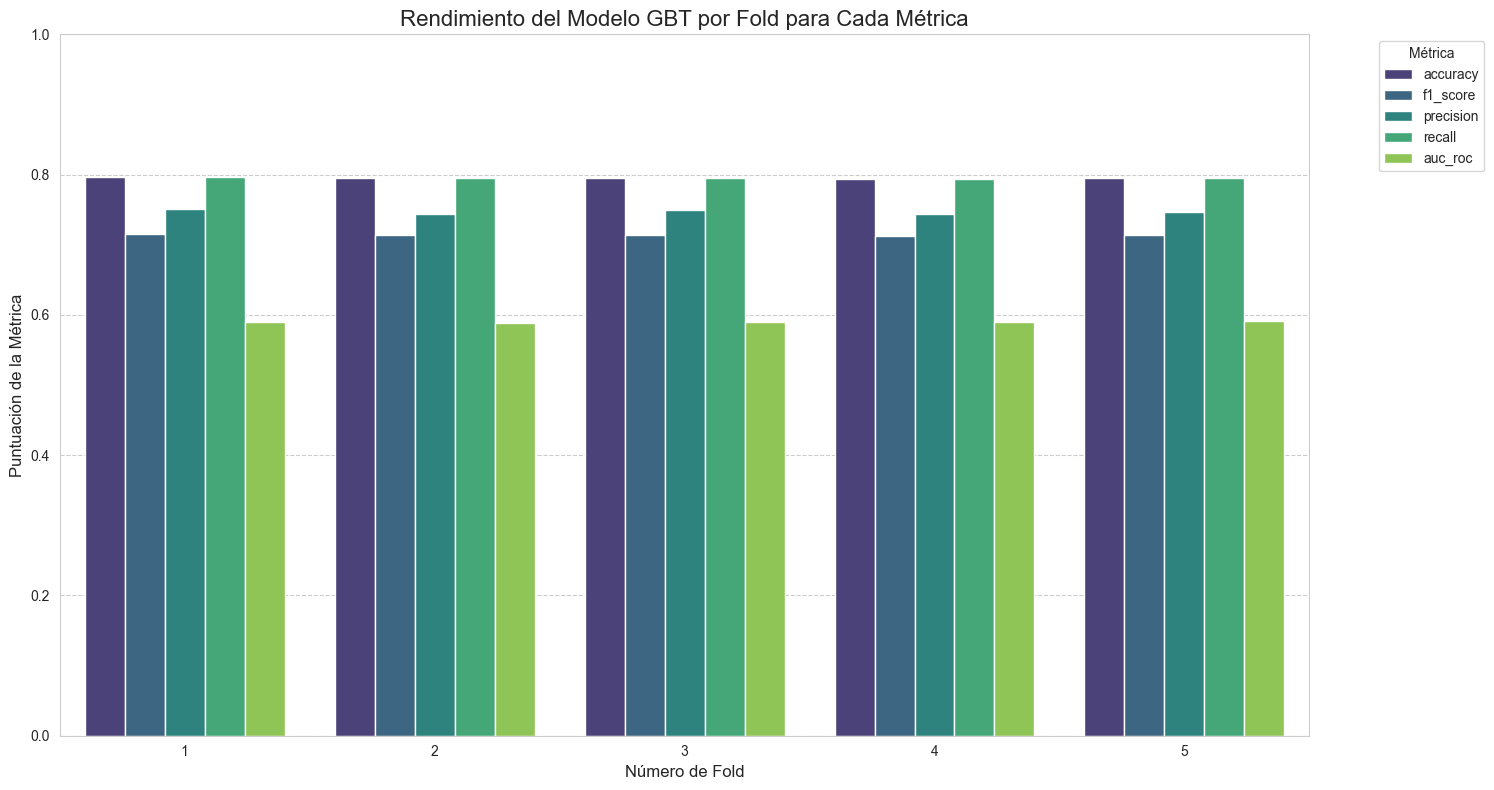

In [38]:
# Establecemos el estilo de Seaborn para gráficos más atractivos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8) # Tamaño general de las figuras

# --- 1. Gráfico de Barras: Rendimiento de cada Métrica por Fold ---
# Usamos Melt para transformar el DataFrame y facilitar la graficación multi-métrica
metrics_to_plot = ['accuracy', 'f1_score', 'precision', 'recall', 'auc_roc']
results_melted = results_df.melt(id_vars=['fold'], value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

plt.figure(figsize=(15, 8))
sns.barplot(x='fold', y='Score', hue='Metric', data=results_melted, palette='viridis')
plt.title('Rendimiento del Modelo GBT por Fold para Cada Métrica', fontsize=16)
plt.xlabel('Número de Fold', fontsize=12)
plt.ylabel('Puntuación de la Métrica', fontsize=12)
plt.ylim(0, 1) # Las métricas están entre 0 y 1
plt.legend(title='Métrica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

La siguiente visualización presenta el comportamiento del modelo GBT a través de los cinco pliegues generados mediante validación cruzada, considerando cinco métricas fundamentales: accuracy, f1_score, precision, recall y AUC-ROC. Esta gráfica de barras permite observar, de forma simultánea y desagregada, el rendimiento del modelo en cada fold, lo cual resulta especialmente valioso en ejercicios de validación, donde se busca evaluar la consistencia y capacidad de generalización del modelo.

Desde una perspectiva analítica, el gráfico revela una notable estabilidad interfold. Las métricas se mantienen uniformes a lo largo de los cinco pliegues, sin presencia de variaciones abruptas ni outliers visibles. Este patrón sugiere que el modelo no está sobreajustando a subconjuntos específicos del conjunto de entrenamiento, y que ha sido capaz de capturar patrones generales de la muestra M con alto grado de reproducibilidad.

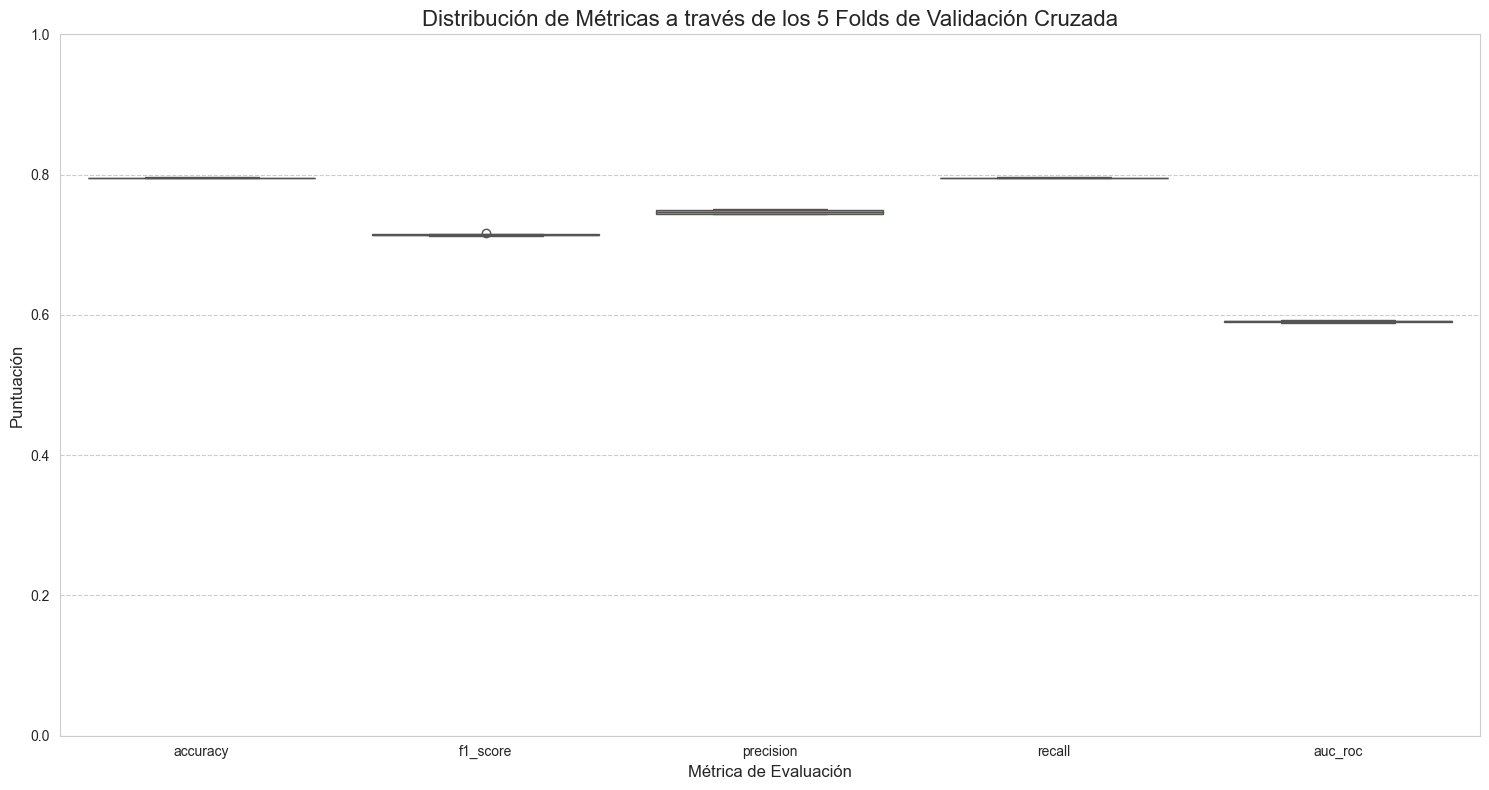

In [41]:
# --- 2. Box Plots: Distribución y Variabilidad de las Métricas a través de los Folds ---
# Esto es excelente para visualizar la variabilidad de los resultados
plt.figure(figsize=(15, 8))
sns.boxplot(x='Metric', y='Score', data=results_melted, hue='Metric', palette='muted', legend=False)
plt.title('Distribución de Métricas a través de los 5 Folds de Validación Cruzada', fontsize=16)
plt.xlabel('Métrica de Evaluación', fontsize=12)
plt.ylabel('Puntuación', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

El gráfico de cajas (boxplot) presentado permite analizar la distribución y variabilidad de las principales métricas de evaluación del modelo GBT (accuracy, f1_score, precision, recall y AUC-ROC) a lo largo de los cinco folds generados mediante validación cruzada. Esta visualización es de especial utilidad en contextos de modelado predictivo, ya que permite identificar posibles inestabilidades o dispersiones significativas en el rendimiento del modelo, las cuales podrían indicar problemas de sobreajuste, sensibilidad a ciertos subconjuntos de datos o variabilidad inherente en la muestra.

En este caso, las cajas correspondientes a cada métrica muestran una variación mínima entre los folds, lo que reafirma nuevamente una alta consistencia en el desempeño del modelo. No se observan valores atípicos (outliers) ni amplitudes intercuartílicas pronunciadas, lo cual respalda empíricamente que el modelo GBT ha logrado una generalización robusta y balanceada. La métrica AUC-ROC, si bien es la más baja en términos absolutos, también presenta una variabilidad muy reducida, lo que reafirma su estabilidad como indicador del poder discriminativo del modelo.

En síntesis, este gráfico aporta una evidencia visual contundente sobre la baja dispersión de los resultados obtenidos a través de los distintos folds, reforzando la confiabilidad de las métricas globales reportadas y validando el uso de GBT como una estrategia eficaz y estable para la clasificación binaria del sentimiento en reseñas de Amazon.

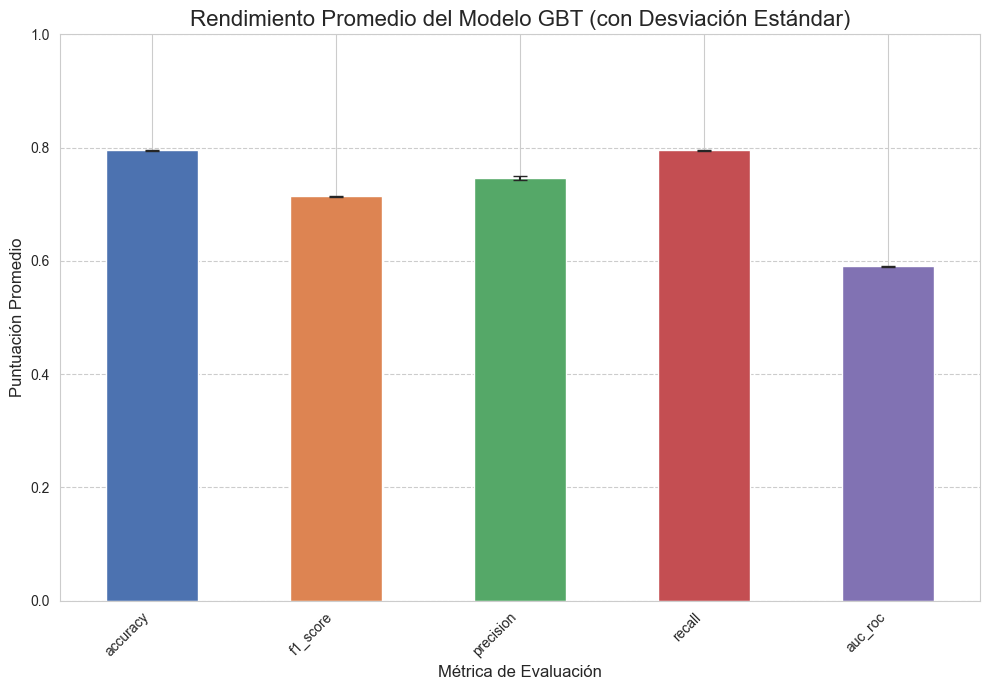

In [40]:
# --- 3. Gráfico de Barras: Media de las Métricas con Desviación Estándar ---
# Esto resume el rendimiento promedio y su variabilidad directamente
mean_scores = results_df[metrics_to_plot].mean()
std_scores = results_df[metrics_to_plot].std()

plt.figure(figsize=(10, 7))
mean_scores.plot(kind='bar', yerr=std_scores, capsize=5, color=sns.color_palette("deep"))
plt.title('Rendimiento Promedio del Modelo GBT (con Desviación Estándar)', fontsize=16)
plt.xlabel('Métrica de Evaluación', fontsize=12)
plt.ylabel('Puntuación Promedio', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

El gráfico de barras presentado muestra el rendimiento promedio del modelo GBT para cada métrica evaluada , acompañado de sus respectivas barras de error que representan la desviación estándar calculada a partir de los resultados de los cinco folds de validación cruzada. Esta visualización es especialmente útil para resumir de forma compacta y comparativa el comportamiento general del modelo, permitiendo observar tanto su eficacia como su estabilidad estadística.

Se aprecia que las métricas accuracy, recall y precision presentan valores promedio elevados, con desviaciones estándar muy reducidas, lo cual sugiere un modelo consistente y fiable en su capacidad de generalización. El f1_score, que balancea precision y recall, también se mantiene en un nivel competitivo (~0.71), indicando un buen equilibrio en el tratamiento de clases desbalanceadas. Por su parte, AUC-ROC, aunque con una media inferior (~0.59), evidencia una estabilidad apreciable en su variación inter-fold, lo que la posiciona como una métrica complementaria útil para interpretar la capacidad discriminativa del modelo.

En conjunto, este gráfico ofrece una perspectiva global y comparativa del rendimiento del modelo GBT, facilitando la identificación de fortalezas métricas clave y validando la elección del enfoque metodológico implementado.

## 6. Discusión y conclusiones

Los resultados obtenidos a lo largo de esta fase experimental permiten realizar un análisis integral sobre el desempeño del modelo GBT aplicado a la tarea de clasificación binaria del sentimiento en reseñas de productos electrónicos en Amazon. En términos generales, se observa un rendimiento consistente entre los distintos folds de validación cruzada, con métricas de accuracy, recall y precision cercanas al 0.79 y desviaciones estándar muy reducidas. Este comportamiento sugiere que el modelo no solo es capaz de generalizar adecuadamente, sino que también mantiene una estabilidad estadística destacable, lo cual es fundamental en problemas de clasificación aplicados a datos reales y desbalanceados.

La implementación de la validación cruzada con estrategia k-fold ha sido un elemento clave para garantizar una evaluación robusta y no sesgada del modelo. Dividir los datos en particiones representativas y disjuntas permite simular distintos escenarios de entrenamiento y prueba, evitando sobreajustes específicos a subconjuntos particulares. En este sentido, se cuidó que los folds preservaran las proporciones originales de las clases objetivo y de las variables de caracterización, lo cual es crucial para evitar distorsiones que comprometan la interpretabilidad de los resultados. La elección y correcta ejecución de esta técnica eleva la calidad del análisis y permite conclusiones más confiables sobre la capacidad de generalización del modelo.

Asimismo, la visualización de los resultados ha desempeñado un rol fundamental. Gráficos como los de barras, boxplots y barras con desviación estándar han permitido condensar información compleja en representaciones claras, visualmente atractivas y de fácil interpretación, tanto para especialistas como para públicos no técnicos. Esta práctica no solo facilita la identificación de patrones de desempeño y posibles outliers, sino que también permite comunicar hallazgos de forma más efectiva, lo cual es indispensable en contextos colaborativos, interdisciplinares y orientados a toma de decisiones.

En conclusión, este entregable no solo ha permitido validar empíricamente un modelo con buen rendimiento para una tarea de clasificación compleja, sino que ha puesto en evidencia la importancia de una metodología rigurosa, del uso de herramientas visuales para análisis, y del cuidado en cada etapa del flujo de trabajo. Como futuros especialistas en inteligencia artificial, es imperativo que reconozcamos que el valor de un modelo no reside únicamente en su precisión, sino también en la forma en que sus resultados se construyen, se interpretan y se comunican. En un mundo guiado cada vez más por datos, la claridad, la transparencia y la capacidad de explicar resultados a audiencias diversas serán habilidades tan esenciales como el conocimiento técnico mismo. Por ello, debemos asumir el compromiso de mantenernos a la vanguardia, pero también de traducir la complejidad en comprensión, y el método en impacto.